In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
az.style.use("arviz-white")

In [4]:
data = bmb.load_data("sleepstudy")
model = bmb.Model("Reaction ~ 1 + Days + (Days | Subject)", data)
idata = model.fit(draws=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset, Reaction_sigma]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 21 seconds.


In [5]:
model.predict_2(idata, inplace=False)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [5]:
X_terms = ["Intercept"] + list(model.common_terms)
Z_terms = list(model.group_specific_terms)
print(X_terms)
print(Z_terms)

['Intercept', 'Days']
['1|Subject', 'Days|Subject']


In [6]:
X_terms = ["Intercept"] + list(model.common_terms)
Z_terms = list(model.group_specific_terms)

b = idata.posterior[X_terms].to_stacked_array("__variables__", ("chain", "draw"))
u = idata.posterior[Z_terms].to_stacked_array("__variables__", ("chain", "draw"))

X = model._design.common.design_matrix
Z = model._design.group.design_matrix
X = xr.DataArray(X, dims=("__obs__", "__variables__"))
Z = xr.DataArray(Z, dims=("__obs__", "__variables__"))

y_hat = xr.dot(X, b) + xr.dot(Z, u)

In [16]:
model

Formula: Reaction ~ 1 + Days + (Days | Subject)
Family name: Gaussian
Link: identity
Observations: 180
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
    Days ~ Normal(mu: 0.0, sigma: 48.8915)

  Group-level effects
    1|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 261.0092))
    Days|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 48.8915))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 56.1721)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [14]:
y_hat

<xarray.DataArray (__obs__: 180, chain: 2, draw: 2000)>
array([[[269.25485423, 243.17512529, 265.93986469, ..., 262.31024427,
         252.31613435, 245.29835971],
        [248.92366478, 254.14903719, 249.50000797, ..., 266.65020834,
         237.72164602, 251.40862415]],

       [[286.95911928, 264.54607359, 284.7846558 , ..., 280.55708704,
         272.30762282, 266.06566555],
        [271.15515492, 272.97702114, 270.61632812, ..., 280.06861264,
         257.3302843 , 270.26768901]],

       [[304.66338434, 285.91702188, 303.62944692, ..., 298.8039298 ,
         292.29911129, 286.83297138],
        [293.38664505, 291.8050051 , 291.73264828, ..., 293.48701694,
         276.93892258, 289.12675387]],

       ...,

       [[350.49820035, 335.00090257, 338.70583643, ..., 329.92770834,
         344.0825966 , 344.74395967],
        [352.85953416, 340.05291995, 329.13613609, ..., 329.19191253,
         334.74374383, 333.22095987]],

       [[361.47133449, 345.58716839, 348.81238212, ..., 343.70381281,
         352.9557953 , 359.50472402],
        [366.18875408, 349.772541  , 338.91294247, ..., 338.59194311,
         346.24335085, 344.51573449]],

       [[372.44446864, 356.17343421, 358.91892781, ..., 357.47991728,
         361.82899399, 374.26548838],
        [379.51797401, 359.49216205, 348.68974884, ..., 347.9919737 ,
         357.74295788, 355.8105091 ]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: __obs__

In [7]:
y_hat = xr.dot(X, b) + xr.dot(Z, u)
y_hat.head(2)

<xarray.DataArray (__obs__: 2, chain: 2, draw: 2)>
array([[[269.25485423, 243.17512529],
        [248.92366478, 254.14903719]],

       [[286.95911928, 264.54607359],
        [271.15515492, 272.97702114]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1
Dimensions without coordinates: __obs__

In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [12]:
model.predict(idata)

In [13]:
idata.posterior

<xarray.Dataset>
Dimensions:              (chain: 2, draw: 2000, Subject__factor_dim: 18,
                          Reaction_obs: 180)
Coordinates:
  * chain                (chain) int64 0 1
  * draw                 (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * Subject__factor_dim  (Subject__factor_dim) <U3 '308' '309' ... '371' '372'
  * Reaction_obs         (Reaction_obs) int64 0 1 2 3 4 ... 175 176 177 178 179
Data variables:
    Intercept            (chain, draw) float64 260.6 259.3 252.6 ... 252.9 247.5
    Days                 (chain, draw) float64 14.57 15.61 13.46 ... 11.25 11.96
    1|Subject_sigma      (chain, draw) float64 28.56 29.96 34.42 ... 30.86 24.4
    Days|Subject_sigma   (chain, draw) float64 8.355 8.709 6.118 ... 4.045 5.957
    Reaction_sigma       (chain, draw) float64 24.49 24.77 24.22 ... 29.18 23.59
    1|Subject            (chain, draw, Subject__factor_dim) float64 8.625 ......
    Days|Subject         (chain, draw, Subject__factor_dim) float64 3.139 ......
    Reaction_mean        (chain, draw, Reaction_obs) float64 269.3 ... 355.8
Attributes:
    created_at:                  2022-10-15T14:02:36.309420
    arviz_version:               0.12.1
    inference_library:           pymc
    inference_library_version:   4.1.7
    sampling_time:               25.89480185508728
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

In [9]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(16, 7.5), sharey=True, sharex=True, dpi=300)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject {subject}", fontsize=14)

    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")

    return axes

/tmp/ipykernel_22567/1199577939.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


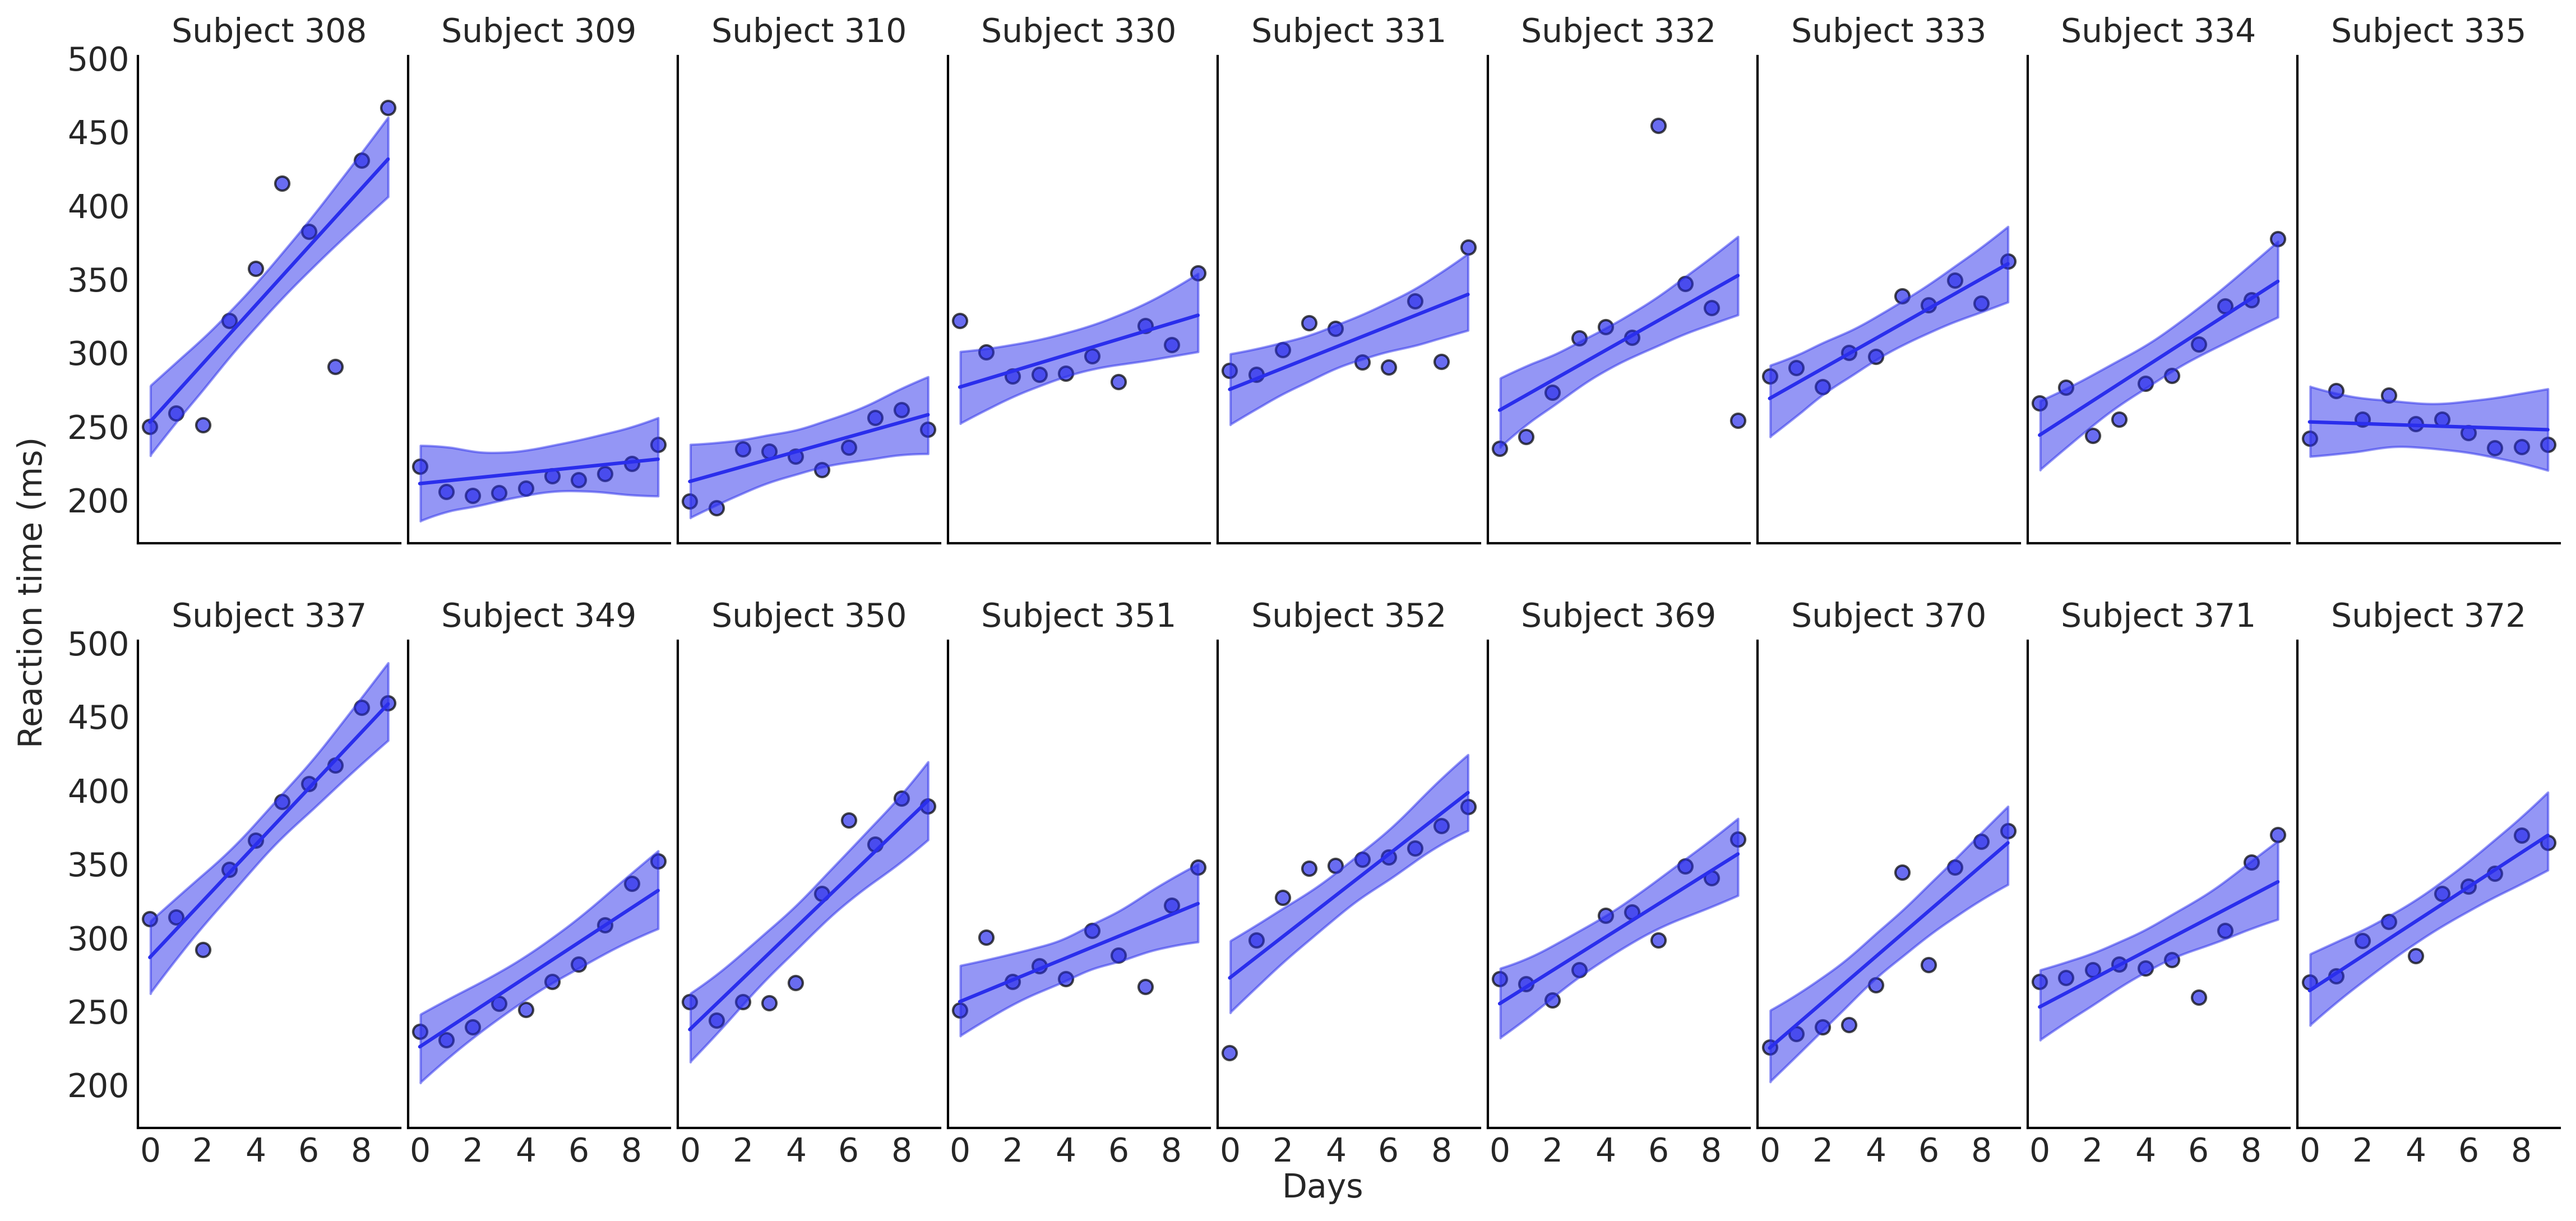

In [12]:
# Plot the data
axes = plot_data(data)

axes_flat = axes.ravel()

# Take the posterior of the mean reaction time
#reaction_mean = y_hat.stack(samples=("draw", "chain")).values
reaction_mean = idata_2.posterior["Reaction_mean"].stack(samples=("draw", "chain")).values

for i, subject in enumerate(data["Subject"].unique()):
    ax = axes_flat[i]
    idx = data.index[data["Subject"]== subject].tolist()
    days = data.loc[idx, "Days"].values
    
    # Plot highest density interval / credibility interval
    az.plot_hdi(days, reaction_mean[idx].T[np.newaxis], color="C0", ax=ax)
    
    # Plot mean regression line
    ax.plot(days, reaction_mean[idx].mean(axis=1), color="C0")